# Run Modes

Running MAGICC in different modes can be non-trivial. In this notebook we show how to set MAGICC's config flags so that it will run as desired for a few different cases.

In [1]:
# NBVAL_IGNORE_OUTPUT
from os.path import join
import datetime
import dateutil
from copy import deepcopy


import numpy as np
import pandas as pd
from scmdata import df_append

from pymagicc import MAGICC6, rcp26, zero_emissions
from pymagicc.io import MAGICCData

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 6)

## Concentration to emissions hybrid

This is MAGICC's default run mode. In this run mode, MAGICC will run with prescribed concentrations (or a quantity which scales linearly with radiative forcing for aerosol species) until a given point in time and will then switch to running in emissions driven mode.

In [3]:
with MAGICC6() as magicc:
    res = magicc.run(rcp26)

In [4]:
# NBVAL_IGNORE_OUTPUT
res.head()

time                                                                                                   1765-01-01  \
climate_model model scenario variable                       todo unit region                                        
MAGICC6       IMAGE RCP26    Atmospheric Concentrations|CO2 N/A  ppm  World                             278.05158   
                                                                      World|Northern Hemisphere|Ocean   278.05158   
                                                                      World|Northern Hemisphere|Land    278.05158   
                                                                      World|Southern Hemisphere|Ocean   278.05158   
                                                                      World|Southern Hemisphere|Land    278.05158   

time                                                                                                   1766-01-01  \
climate_model model scenario variable                       todo unit region                                        
MAGICC6       IMAGE RCP26    Atmospheric Concentrations|CO2 N/A  ppm  World                             278.16073   
                                                                      World|Northern Hemisphere|Ocean   278.16073   
                                                                      World|Northern Hemisphere|Land    278.16073   
                                                                      World|Southern Hemisphere|Ocean   278.16073   
                                                                      World|Southern Hemisphere|Land    278.16073   

time                                                                                                   1767-01-01  \
climate_model model scenario variable                       todo unit region                                        
MAGICC6       IMAGE RCP26    Atmospheric Concentrations|CO2 N/A  ppm  World                             278.28006   
                                                                      World|Northern Hemisphere|Ocean   278.28006   
                                                                      World|Northern Hemisphere|Land    278.28006   
                                                                      World|Southern Hemisphere|Ocean   278.28006   
                                                                      World|Southern Hemisphere|Land    278.28006   

time                                                                                                   1768-01-01  \
climate_model model scenario variable                       todo unit region                                        
MAGICC6       IMAGE RCP26    Atmospheric Concentrations|CO2 N/A  ppm  World                             278.40604   
                                                                      World|Northern Hemisphere|Ocean   278.40604   
                                                                      World|Northern Hemisphere|Land    278.40604   
                                                                      World|Southern Hemisphere|Ocean   278.40604   
                                                                      World|Southern Hemisphere|Land    278.40604   

time                                                                                                   1769-01-01  \
climate_model model scenario variable                       todo unit region                                        
MAGICC6       IMAGE RCP26    Atmospheric Concentrations|CO2 N/A  ppm  World                             278.53513   
                                                                      World|Northern Hemisphere|Ocean   278.53513   
                                                                      World|Northern Hemisphere|Land    278.53513   
                                                                      World|Southern Hemisphere|Ocean   278.53513   
                  

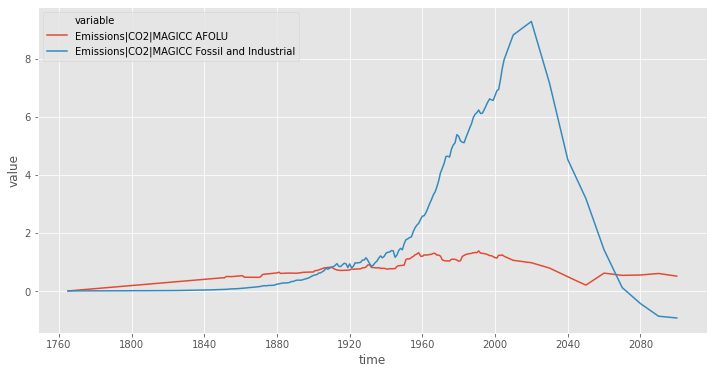

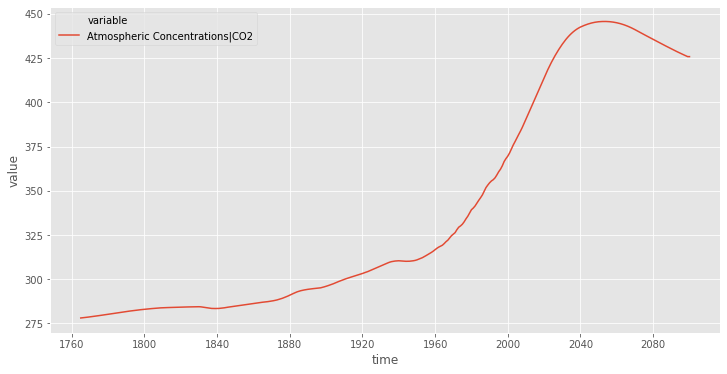

In [5]:
plt.figure()
res.filter(variable="Emis*CO2*", region="World").line_plot(hue="variable")
plt.figure()
res.filter(variable="Atmos*Conc*CO2", region="World").line_plot(hue="variable");

The switches which control the time at which MAGICC switches from concentrations driven to emissions driven are all in the form `GAS_SWITCHFROMXXX2EMIS_YEAR` e.g. `CO2_SWITCHFROMCONC2EMIS_YEAR` and `BCOC_SWITCHFROMRF2EMIS_YEAR`. 

Changing the value of these switches will alter how MAGICC runs.

In [6]:
# NBVAL_IGNORE_OUTPUT
df = deepcopy(rcp26)
df.set_meta("RCP26_altered_co2_switch", name="scenario")
with MAGICC6() as magicc:
    res = res.append(magicc.run(df, co2_switchfromconc2emis_year=1850))

AttributeError: 'MAGICCData' object has no attribute 'set_meta'

In [ ]:
plt.figure()
res.filter(variable="Emis*CO2*", region="World").line_plot(hue="variable")
plt.figure()
res.filter(variable="Atmos*Conc*CO2", region="World").line_plot(hue="variable");

In [ ]:
# NBVAL_IGNORE_OUTPUT
res.timeseries()

As we can see, the emissions remain unchanged but the concentrations are altered as MAGICC is now running emissions driven from 1850 rather than 2005 (the default).

To get a fully emissions driven run, you need to change all of the relevant `GAS_SWITCHXXX2EMIS_YEAR` flags.

## CO$_2$ Emissions Driven Only

We can get a CO$_2$ emissions only driven run like shown.

In [ ]:
df = zero_emissions.timeseries()

time = zero_emissions["time"]
df.loc[
    (
        df.index.get_level_values("variable")
        == "Emissions|CO2|MAGICC Fossil and Industrial"
    ),
    :,
] = np.linspace(0, 30, len(time))

scen = MAGICCData(df)
scen.filter(variable="Em*CO2*Fossil*").line_plot(
    x="time", label="CO2 Fossil", hue=None
)
scen.filter(variable="Em*CO2*Fossil*", keep=False).line_plot(
    x="time", label="Everything else", hue=None
);

In [ ]:
# NBVAL_IGNORE_OUTPUT
with MAGICC6() as magicc:
    co2_only_res = magicc.run(
        scen,
        endyear=scen["time"].max().year,
        rf_total_constantafteryr=5000,
        rf_total_runmodus="CO2",
        co2_switchfromconc2emis_year=min(scen["time"]).year,
    )

In [ ]:
for v in [
    "Emis*CO2*",
    "Atmos*Conc*CO2",
    "Radiative Forcing",
    "Surface Temperature",
]:
    plt.figure()
    co2_only_res.filter(variable=v, region="World").line_plot(hue="variable")

## Prescribed Forcing Driven Only

It is also possible to examine MAGICC's response to a prescribed radiative forcing only.

In [ ]:
time = zero_emissions["time"]

forcing_external = 2.0 * np.arange(0, len(time)) / len(time)
forcing_ext = MAGICCData(
    forcing_external,
    index=time,
    columns={
        "scenario": ["idealised"],
        "model": ["unspecified"],
        "climate_model": ["unspecified"],
        "variable": ["Radiative Forcing|Extra"],
        "unit": ["W / m^2"],
        "todo": ["SET"],
        "region": ["World"],
    },
)
forcing_ext.metadata = {
    "header": "External radiative forcing with linear increase"
}
forcing_ext.line_plot(x="time");

In [ ]:
with MAGICC6() as magicc:
    forcing_ext_filename = "CUSTOM_EXTRA_RF.IN"
    forcing_ext.write(
        join(magicc.run_dir, forcing_ext_filename), magicc.version
    )
    ext_forc_only_res = magicc.run(
        rf_extra_read=1,
        file_extra_rf=forcing_ext_filename,
        rf_total_runmodus="QEXTRA",
        endyear=max(time).year,
        rf_initialization_method="ZEROSTARTSHIFT",  # this is default but to be sure
        rf_total_constantafteryr=5000,
    )

In [ ]:
ext_forc_only_res.filter(
    variable=["Radiative Forcing", "Surface Temperature"], region="World"
).line_plot(hue="variable")

## Zero Temperature Output

Getting MAGICC to return zero for its temperature output is surprisingly difficult. To help address this, we add the `set_zero_config` method to our MAGICC classes.

In [ ]:
print(MAGICC6.set_zero_config.__doc__)

In [ ]:
# NBVAL_IGNORE_OUTPUT
with MAGICC6() as magicc:
    magicc.set_zero_config()
    res_zero = magicc.run()

In [ ]:
res_zero.filter(
    variable=["Surface Temperature", "Radiative Forcing"], region="World"
).line_plot(x="time");

## CO$_2$ Emissions and Prescribed Forcing

It is also possible to run MAGICC in a mode which is CO$_2$ emissions driven but also includes a prescribed external forcing.

In [ ]:
df = zero_emissions.timeseries()

time = zero_emissions["time"]
emms_fossil_co2 = (
    np.linspace(0, 3, len(time))
    - (1 + (np.arange(len(time)) - 500) / 500) ** 2
)
df.loc[
    (
        df.index.get_level_values("variable")
        == "Emissions|CO2|MAGICC Fossil and Industrial"
    ),
    :,
] = emms_fossil_co2

scen = MAGICCData(df)
scen.filter(variable="Em*CO2*Fossil*").line_plot(x="time", hue="variable")
scen.filter(variable="Em*CO2*Fossil*", keep=False).line_plot(
    x="time", label="Everything Else"
)

forcing_external = 3.0 * np.arange(0, len(time)) / len(time)
forcing_ext = MAGICCData(
    forcing_external,
    index=time,
    columns={
        "scenario": ["idealised"],
        "model": ["unspecified"],
        "climate_model": ["unspecified"],
        "variable": ["Radiative Forcing|Extra"],
        "unit": ["W / m^2"],
        "todo": ["SET"],
        "region": ["World"],
    },
)
forcing_ext.metadata = {
    "header": "External radiative forcing with linear increase"
}
forcing_ext.line_plot(x="time", hue="variable");

In [ ]:
scen.timeseries()

In [ ]:
with MAGICC6() as magicc:
    magicc.set_zero_config()  # very important, try commenting this out and see what happens
    forcing_ext_filename = "CUSTOM_EXTRA_RF.IN"
    forcing_ext.write(
        join(magicc.run_dir, forcing_ext_filename), magicc.version
    )
    co2_emms_ext_forc_res = magicc.run(
        scen,
        endyear=scen["time"].max().year,
        co2_switchfromconc2emis_year=min(scen["time"]).year,
        rf_extra_read=1,
        file_extra_rf=forcing_ext_filename,
        rf_total_runmodus="ALL",  # default but just in case
        rf_initialization_method="ZEROSTARTSHIFT",  # this is default but to be sure
        rf_total_constantafteryr=5000,
    )

In [ ]:
plt.figure()
co2_emms_ext_forc_res.filter(variable="Emis*CO2*", region="World").line_plot(
    x="time", hue="variable"
)
plt.figure()
co2_emms_ext_forc_res.filter(
    variable="Atmos*Conc*CO2", region="World"
).line_plot(x="time")
plt.figure()
co2_emms_ext_forc_res.filter(
    variable="Radiative Forcing", region="World"
).line_plot(x="time")
plt.figure()
co2_emms_ext_forc_res.filter(
    variable="Surface Temperature", region="World"
).line_plot(x="time");

If we adjust MAGICC's CO$_2$ temperature feedback start year, it is easier to see what is going on.

In [ ]:
with MAGICC6() as magicc:
    magicc.set_zero_config()

    forcing_ext_filename = "CUSTOM_EXTRA_RF.IN"
    forcing_ext.write(
        join(magicc.run_dir, forcing_ext_filename), magicc.version
    )
    for temp_feedback_year in [2000, 2100, 3000]:
        scen["scenario"] = "idealised_{}_CO2_temperature_feedback".format(temp_feedback_year)

        co2_emms_ext_forc_res.append(
            magicc.run(
                scen,
                endyear=scen["time"].max().year,
                co2_switchfromconc2emis_year=min(scen["time"]).year,
                rf_extra_read=1,
                file_extra_rf=forcing_ext_filename,
                rf_total_runmodus="ALL",
                rf_initialization_method="ZEROSTARTSHIFT",
                rf_total_constantafteryr=5000,
                co2_tempfeedback_yrstart=temp_feedback_year,
            )
        )

In [ ]:
co2_emms_ext_forc_res.filter(variable="Emis*CO2*", region="World").line_plot(
    x="time", hue="variable"
)
plt.figure()
co2_emms_ext_forc_res.filter(
    variable="Atmos*Conc*CO2", region="World"
).line_plot(x="time")
plt.figure()
co2_emms_ext_forc_res.filter(
    variable="Radiative Forcing", region="World"
).line_plot(x="time")
plt.figure()
co2_emms_ext_forc_res.filter(
    variable="Surface Temperature", region="World"
).line_plot(x="time");

## CO$_2$ Concentrations Driven

In [ ]:
time = zero_emissions["time"]

co2_concs = 278 * np.ones_like(time)
co2_concs[105:] = 278 * 1.01 ** (np.arange(0, len(time[105:])))

co2_concs = MAGICCData(
    co2_concs,
    index=time,
    columns={
        "scenario": ["1%/yr CO2"],
        "model": ["unspecified"],
        "climate_model": ["unspecified"],
        "variable": ["Atmospheric Concentrations|CO2"],
        "unit": ["ppm"],
        "todo": ["SET"],
        "region": ["World"],
    },
)
co2_concs = co2_concs.filter(year=range(1700, 2001))
time = co2_concs["time"]
co2_concs.metadata = {"header": "1%/yr atmospheric CO2 concentration increase"}
co2_concs.line_plot(x="time");

In [ ]:
with MAGICC6() as magicc:
    co2_conc_filename = "1PCT_CO2_CONC.IN"
    co2_concs.write(join(magicc.run_dir, co2_conc_filename), magicc.version)
    co2_conc_driven_res = magicc.run(
        file_co2_conc=co2_conc_filename,
        co2_switchfromconc2emis_year=max(time).year,
        co2_tempfeedback_switch=1,
        co2_tempfeedback_yrstart=1870,
        co2_fertilization_yrstart=1870,
        rf_total_runmodus="CO2",
        rf_total_constantafteryr=max(time).year,
        endyear=max(time).year,
        out_inverseemis=1,
    )

In [ ]:
plt.figure()
co2_conc_driven_res.filter(
    variable="Inverse Emis*CO2*", region="World"
).line_plot()
plt.figure()
co2_conc_driven_res.filter(
    variable="Atmos*Conc*CO2", region="World"
).line_plot()
plt.figure()
co2_conc_driven_res.filter(
    variable="Radiative Forcing", region="World"
).line_plot()
plt.figure()
co2_conc_driven_res.filter(
    variable="Surface Temperature", region="World"
).line_plot();